# Denoising Autoencoders

In [1]:
import sys
sys.path.append("..")

import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


# Load dataset

```bash
bash load_mnist.sh

```

In [2]:
from data import BatchIterator, load_mnist, encode_labels

# load mnist data
train_inputs, train_targets = load_mnist('./data/', kind='train')
test_inputs, test_targets = load_mnist('./data/', kind='t10k')
# normalize input values using min max scaler style
X_train = (train_inputs / 255. - 0.5).reshape(-1, 28, 28, 1)
X_test = (test_inputs / 255. - 0.5).reshape(-1, 28, 28, 1)

In [3]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

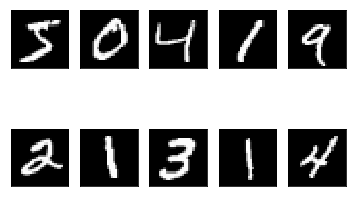

In [11]:
def show_image(x):
    x = x.reshape(28, 28)
    plt.imshow(np.clip(x + 0.5, 0, 1), cmap='gray')
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

plt.title('sample images')

num = 10
for i in range(num):
    plt.subplot(2,num // 2,i+1)
    show_image(X_train[i, :, :])

# Apply Noise

In [12]:
z = np.ones((28, 28, 1))
z[8:22, 8:22, :] = 0

X_train_noise = X_train * z
X_test_noise = X_test * z

# Show before and after Noise

Original


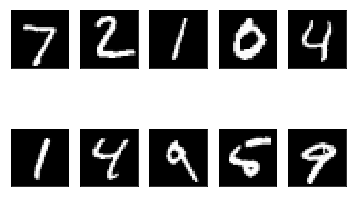

With Noise


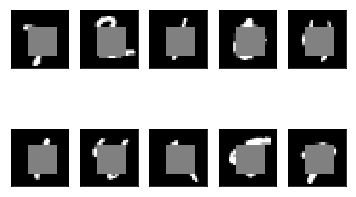

In [16]:
print('Original')

num = 10
for i in range(num):
    plt.subplot(2,num // 2,i+1)
    show_image(X_test[i, :, :, :])
plt.show()

print('With Noise')

for i in range(num):
    plt.subplot(2,num // 2,i+1)
    show_image(X_test_noise[i, :, :, :])

In [17]:
X_train_noise.shape, X_test_noise.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

# Convolutional autoencoder

In [36]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(16, (3, 3), padding='same', activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(32, (3, 3), padding='same', activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    
    shape_code = (7, 7, 32)
    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense((shape_code[0] * shape_code[1] * shape_code[2])))
    
    decoder.add(L.Reshape(shape_code))
    
    decoder.add(L.Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    
    decoder.add(L.Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    
    return encoder, decoder

In [45]:
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.InteractiveSession()

/home/dsysoev/.virtualenvs/py3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [67]:
code_size = 8
IMG_SHAPE = (28, 28, 1)

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
encoder.summary(), decoder.summary(), IMG_SHAPE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 12552     
Total params: 17,352
Trainable params: 17,352
Non-trainable params: 0
_________________________________________________________________
______

(None, None, (28, 28, 1))

In [68]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [69]:
autoencoder.fit(x=X_train_noise, y=X_train, epochs=10,
                validation_data=[X_test_noise, X_test],
                verbose=1,
                initial_epoch=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 401us/step - loss: 0.0484 - val_loss: 0.0409
Epoch 2/10
60000/60000 [==============================] - 27s 452us/step - loss: 0.0375 - val_loss: 0.0340
Epoch 3/10
60000/60000 [==============================] - 27s 457us/step - loss: 0.0330 - val_loss: 0.0318
Epoch 4/10
60000/60000 [==============================] - 28s 472us/step - loss: 0.0313 - val_loss: 0.0306
Epoch 5/10
60000/60000 [==============================] - 28s 475us/step - loss: 0.0304 - val_loss: 0.0298
Epoch 6/10
60000/60000 [==============================] - 29s 477us/step - loss: 0.0299 - val_loss: 0.0295
Epoch 7/10
60000/60000 [==============================] - 28s 466us/step - loss: 0.0294 - val_loss: 0.0292
Epoch 8/10
60000/60000 [==============================] - 29s 483us/step - loss: 0.0291 - val_loss: 0.0288
Epoch 9/10
60000/60000 [==============================] - 29s 478us/step - loss: 0.0288 - val_

In [70]:
reconstruction_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Convolutional autoencoder MSE: {:.4f}".format(reconstruction_mse))

Convolutional autoencoder MSE: 0.0282


In [71]:
def visualize(img, img_true, encoder, decoder, show_code=False):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,4,1)
    plt.title("Input")
    show_image(img)

    plt.subplot(1,4,2)
    plt.title("Reconstructed")
    show_image(reco)
    
    plt.subplot(1,4,3)
    plt.title("Original")
    show_image(img_true)
        
    if show_code:
        plt.subplot(1,4,4)
        plt.title("Code")
        plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.show()


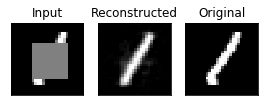

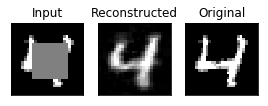

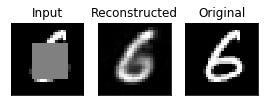

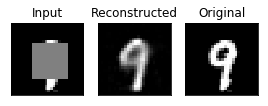

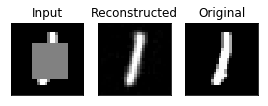

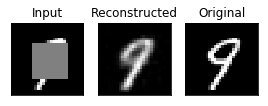

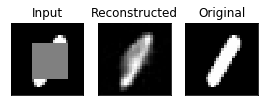

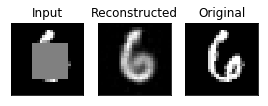

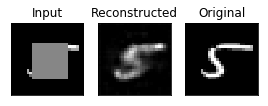

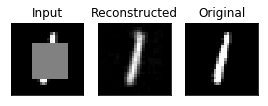

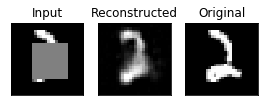

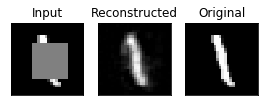

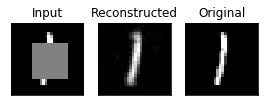

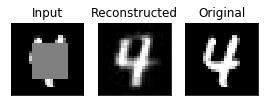

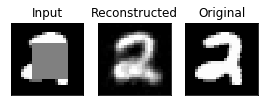

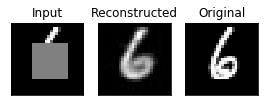

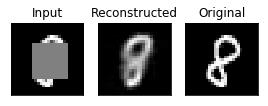

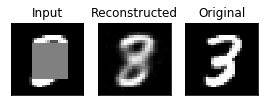

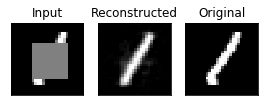

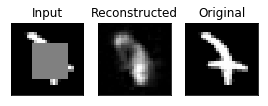

In [73]:
np.random.seed(104)
for i in np.random.choice(range(X_test_noise.shape[0]), size=20):
    visualize(X_test_noise[i], X_test[i], encoder, decoder, show_code=False)